
#### SIMULAÇÃO DOS CONTROLES P E PI NO SISTEMA DISCRETIZADO


Após análise de cada simulação, a escolha do modelo discreto feita no relatório neste relatorio, foi selecionada pelo menor erro médio quadrático e pela melhor resposta apresentados nos gráficos. Esses requisitos foram atendidos pelo sistema de terceira ordem, apresentado logo a baixo:


In [1]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 4.7 MB/s eta 0:00:00


In [35]:
import control as ct
import numpy as np
from control.matlab import *
import matplotlib.pyplot as plt
from scipy.signal import square

Declarando a função de transferência do modelo discretizado escolhido:

In [58]:
NUM = np.array([ 0.02899,0.0852,0.09638])      #Numerador
DEN = np.array([ 1, -0.5187 ,   0.1329 , -0.3164])    #Denominador
Ts = 0.02                                      #Amostragem
Gz = ct.tf(NUM,DEN,Ts)                              #Função de transf.

print('Modelo discretizado: \n',Gz)

Modelo discretizado: 
 
  0.02899 z^2 + 0.0852 z + 0.09638
------------------------------------
z^3 - 0.5187 z^2 + 0.1329 z - 0.3164

dt = 0.02



In [59]:
ct.damp(Gz)
ct.zeros(Gz)


    Eigenvalue (pole)       Damping     Frequency
               0.8237             1         9.698
   -0.1525   +0.6007j        0.2543         94.06
   -0.1525   -0.6007j        0.2543         94.06


array([-1.46947223+1.07946563j, -1.46947223-1.07946563j])

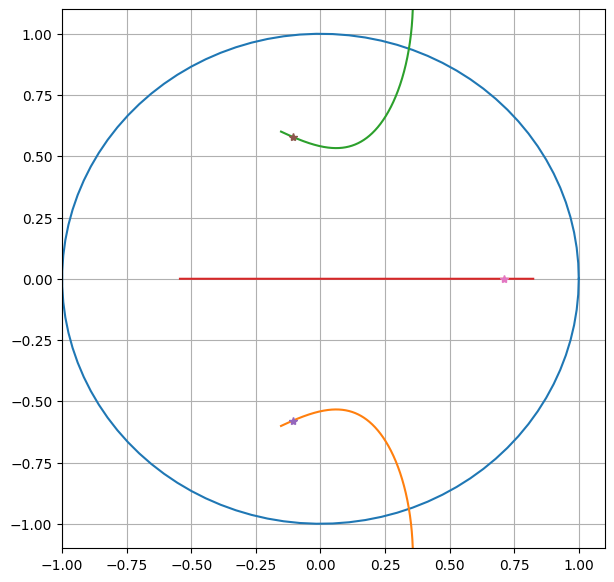

In [60]:
kvect = np.arange(0,12,0.01)
rlist,_ = ct.rlocus(Gz, kvect=kvect, plot = False)

teta = np.linspace(0,2*np.pi,100)
K = 0.73
plt.figure(figsize=(7,7))
plt.plot(np.cos(teta),np.sin(teta))
plt.plot(np.real(rlist[:]),np.imag(rlist[:]))
plt.plot(np.real(rlist[kvect==K]),np.imag(rlist[kvect==K]), '*')
plt.axis([-1,1.1,-1.1,1.1])
plt.grid()
plt.show()

Alguns pontos devem ser levantados quanto a imagem acima, percebe-se que o sistema é estável, ou seja, seus polos estão dentro do círculo.

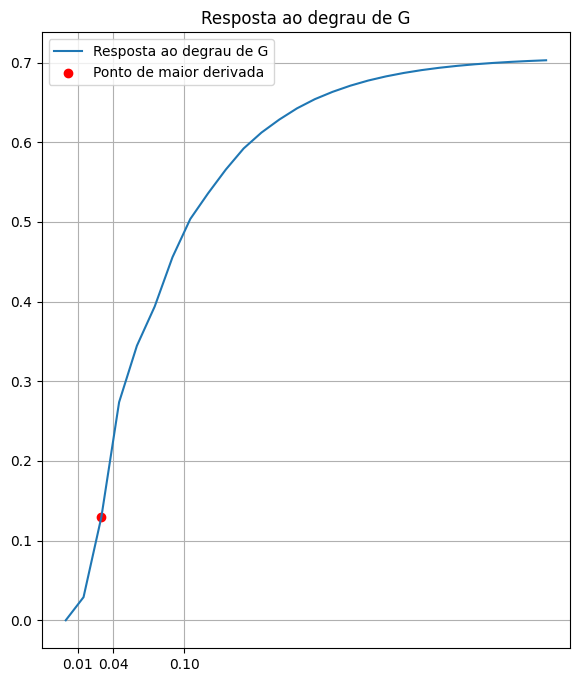

In [61]:
Ts1 = 0.015
G2 = ct.tf(NUM, DEN, Ts1)
T1, yG2 = ct.step_response(G2, T=0.4)

dyG2 = np.gradient(yG2, T1)


max_index = np.argmax(dyG2)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(T1, yG2, label='Resposta ao degrau de G')
plt.scatter(T1[max_index], yG2[max_index], color='red', label='Ponto de maior derivada')
plt.xticks([0.01,0.04,0.1])
plt.grid()
plt.title('Resposta ao degrau de G')
plt.legend()
plt.show()


A elaboração dos controladores P e PI foram projetados através do método de Ziegler Nichols.

Para o controlador proporcional, temos a equação abaixo:
$$
\begin{align*}
P =  \frac{T}{L}\\
\end{align*}
$$

onde os valores de T e L são calculados através do gráfico acima.

$$
\begin{align*}
&T = 0.1 - 0.04 = 0.06\\
&L = 0.04
\end{align*}
$$

Assim, temos que o controle proporcional é:
$$
\begin{align*}
P =  \frac{0.06}{0.04} = 1.5\\
\end{align*}
$$


Para o controlador proporcional integral, temos a equação a baixo:
$$
\begin{align*}
PI =  0.9\cdot \frac{T}{L}\\
\end{align*}
$$

Logo:



$$PI =  0.9\cdot \frac{0.06}{0.04} = 1.35$$

$$ \tau_i=\frac{L}{0.3}= \frac{0.04}{0.3}=0.13 $$



Em conjunto do método descrito anteriormente, o projeto do controlador PI, foi baseado pela equação abaixo:




$$G(S) = K_p + \frac{K_i}{S}$$

$$= \frac{S \cdot K_p + K_i}{S} $$

$$= K_p \cdot \frac{S + \frac{K_i}{K_p}}{S} = \frac{K_c(S+Z)}{S}
$$


Assim, temos:




$$K_i = \frac{K_p}{\tau_i} = \frac{1.35}{0.13} = 10.38 $$

$$a = \frac{K_i}{K_p} = \frac{10.38}{1.35} = 7.68$$



Sendo que $K_c$ = $K_p$ = $PI$

# Controle P

A seguir, temos uma simulação a resposta ao degrau.

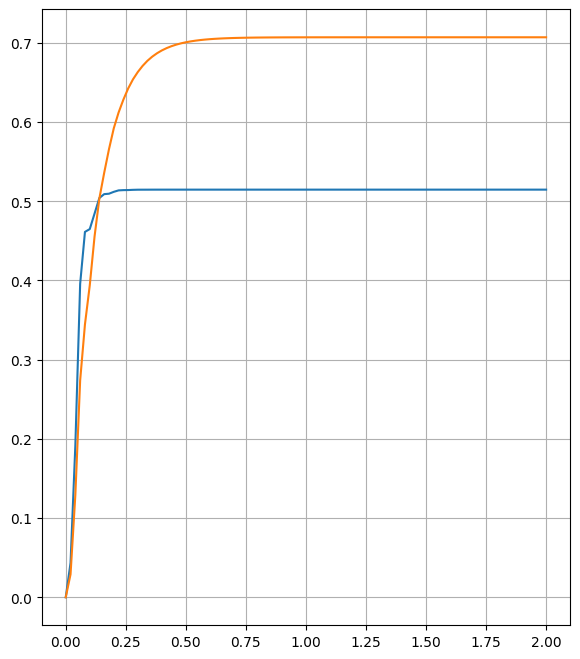

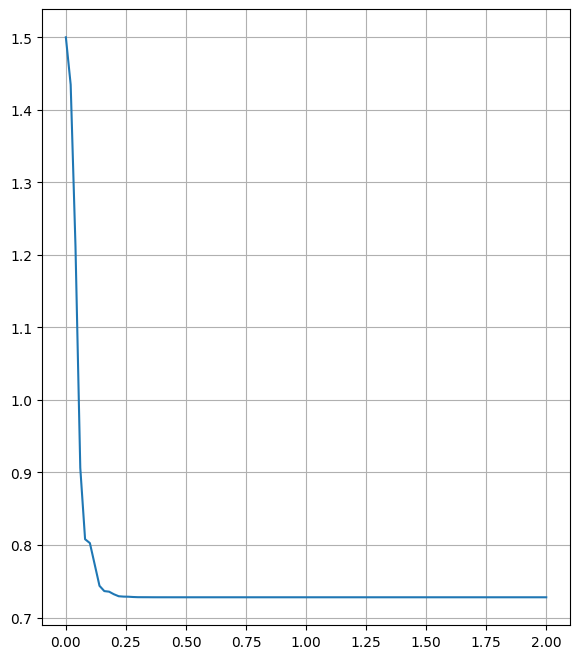

In [62]:
Kp = 1.5                         #Valor de KP

H = ct.feedback(Kp*Gz,1,sign=-1)   #Sistema em maalha fechada
C = ct.feedback(Kp,Gz,sign=-1)     #Controlador

T, yGz = ct.step_response(Gz,T=2)  #resp_degrau em malha aberta
T, yH = ct.step_response(H,T=2)    #resp_degrau em malha fechada
T, yC = ct.step_response(C,T=2)    #controlador

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(T,yH)
plt.plot(T,yGz)
plt.grid()
plt.show()
plt.figure(figsize=(15,8))
plt.subplot(122)
plt.plot(T,yC)
plt.grid()
plt.show()

Além disso, na realização da simulação, temos uma análise feita referente a uma onda quadrada:

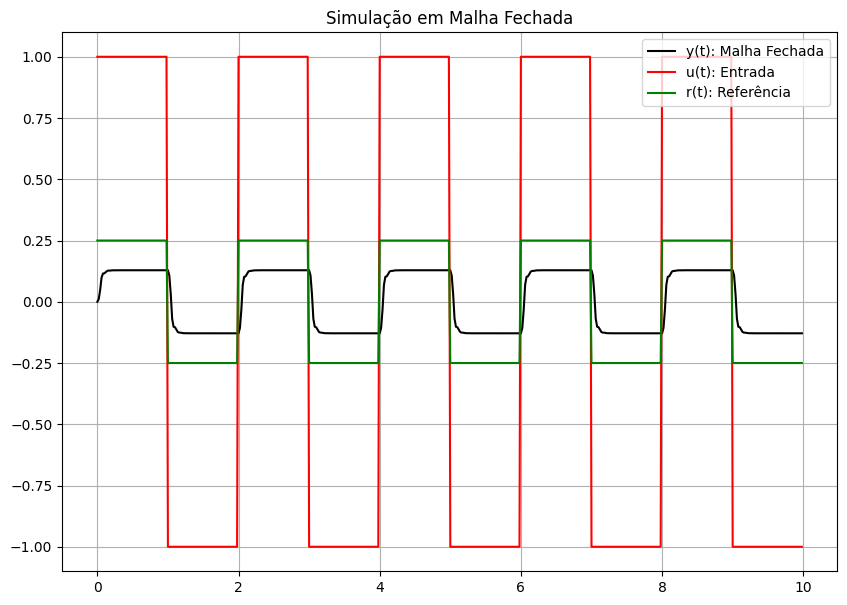

In [63]:
# Define o sinal de entrada e sinal de referência
N = 500
Amplutude = 1
freq = 0.5
Fs = 50
Ts =1/Fs

n = np.arange(0,N)
tempo = n*Ts

sinal_de_entrada = Amplutude*square(2*np.pi*freq*n*Ts)

sinal_de_referencia = 0.25*Amplutude*square(2*np.pi*freq*n*Ts)



# Simulação do Sistema em Malha Fechada para Onda Quadrada

_, y_malha_fechada = ct.forced_response(H, T = tempo, U = sinal_de_referencia)

# Simulação do Sistema em Malha Fechada para Onda Quadrada

plt.figure(figsize=(10,7))
plt.plot(tempo, y_malha_fechada, '-k', label = "y(t): Malha Fechada")
#plt.plot(tempo, , '-b', label ="y(t): Malha aberta")
plt.plot(tempo, sinal_de_entrada, '-r', label ="u(t): Entrada")
plt.plot(tempo, sinal_de_referencia, '-g', label ="r(t): Referência")
plt.title('Simulação em Malha Fechada')
plt.legend()
plt.grid()
plt.show()

Percebe-se que na simulação, o sistema não zera o erro em regime permanente. No entanto, vemos que em malha fechada o controlador $K_p$ acompanha o sinal de entrada.

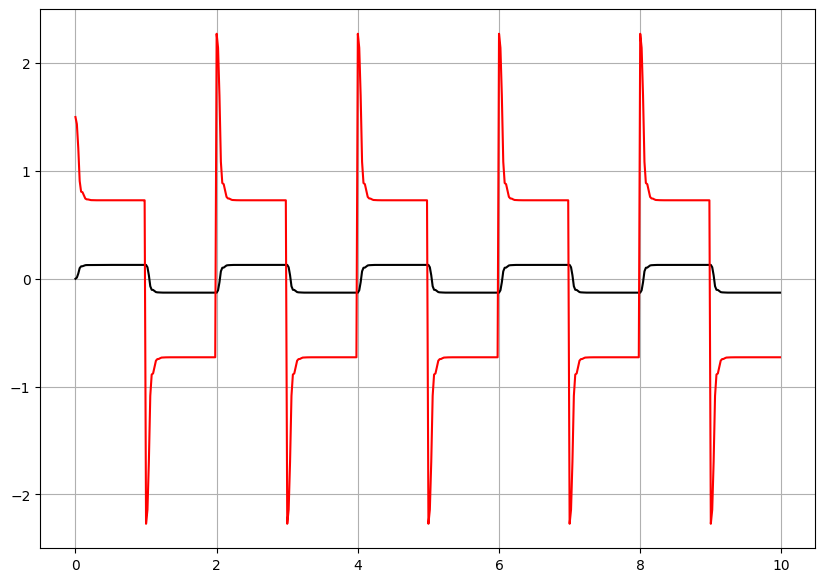

In [14]:

# Simulação para obter o Sinal de Controle

_, sinal_controle = ct.forced_response(C, T = tempo, U = sinal_de_entrada)

# Simulação do Sistema em Malha Fechada para Onda Quadrada

plt.figure(figsize=(10,7))
plt.plot(tempo, y_malha_fechada, '-k')
#plt.plot(tempo, y_malha_aberta, '-b')
plt.plot(tempo, sinal_controle, '-r', label= "Sinal de Controle")
plt.grid()
plt.show()



In [64]:
ct.damp(H)
#ct.zeros(H)
ct.step_info(H)


    Eigenvalue (pole)       Damping     Frequency
               0.5589             1         29.09
  -0.04183   +0.5529j        0.3372         87.44
  -0.04183   -0.5529j        0.3372         87.44


{'RiseTime': 0.060000000000000005,
 'SettlingTime': 0.16,
 'SettlingMin': 0.4649076138561319,
 'SettlingMax': 0.514711034701909,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.514711034701909,
 'PeakTime': 1.28,
 'SteadyStateValue': 0.514711034701909}

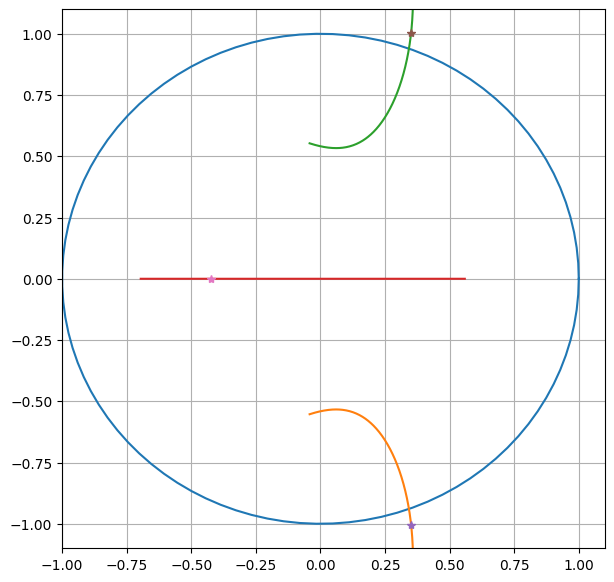

In [65]:
kvect = np.arange(0,12,0.01)
rlist,_ = ct.rlocus(H, kvect=kvect, plot = False)

teta = np.linspace(0,2*np.pi,100)
K = 4.5
plt.figure(figsize=(7,7))
plt.plot(np.cos(teta),np.sin(teta))
plt.plot(np.real(rlist[:]),np.imag(rlist[:]))
plt.plot(np.real(rlist[kvect==K]),np.imag(rlist[kvect==K]), '*')
plt.axis([-1,1.1,-1.1,1.1])
plt.grid()
plt.show()

# Controle PI

In [66]:
Kpi = 1.35
a = 7.68
Gzc = ct.tf([Kpi,Kpi*a],[1,0])
print(Gzc)

Gzd = ct.c2d(Gzc,Ts,'tustin')
print(Gzd)



1.35 s + 10.37
--------------
      s


1.454 z - 1.246
---------------
     z - 1

dt = 0.02



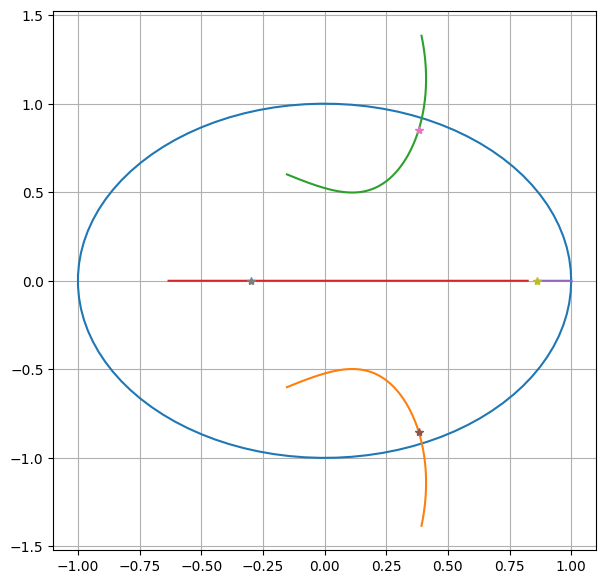

In [67]:
kvect = np.arange(0,12,0.01)
rlist,_ = ct.rlocus(Gzd*Gz, kvect=kvect, plot = False)

teta = np.linspace(0,2*np.pi,100)
plt.figure(figsize=(7,7))
plt.plot(np.cos(teta),np.sin(teta))
plt.plot(np.real(rlist[:]),np.imag(rlist[:]))
plt.plot(np.real(rlist[kvect==K]),np.imag(rlist[kvect==K]), '*')
# plt.axis([-1,1.1,-1.1,1.1])
plt.grid()
plt.show()

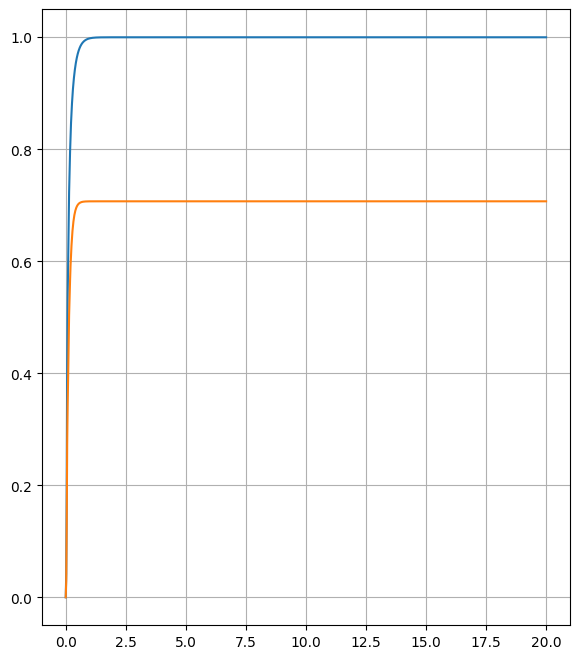

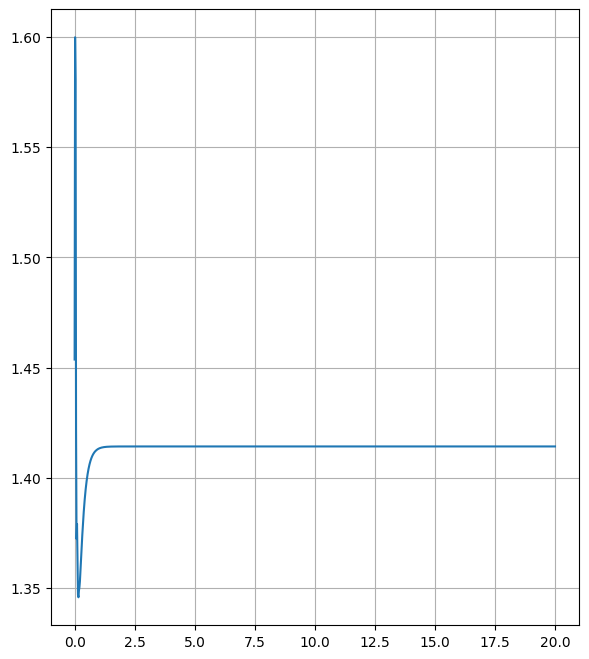

In [68]:

H2 = ct.feedback(Gzd*Gz , 1, sign=-1)
C = ct.feedback(Gzd, Gz, sign=-1)

T, yG = ct.step_response(Gz,T=20)
T, yH = ct.step_response(H2,T=20)
T, yC = ct.step_response(C,T=20)

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(T,yH)
plt.plot(T,yG)
plt.grid()
plt.show()
plt.figure(figsize=(15,8))
plt.subplot(122)
plt.plot(T,yC)
plt.grid()
plt.show()

In [69]:
ct.damp(H2)
ct.step_info(H2)

    Eigenvalue (pole)       Damping     Frequency
               0.8959             1         5.498
               0.7082             1         17.25
  -0.06374   +0.5526j        0.3287         89.24
  -0.06374   -0.5526j        0.3287         89.24


{'RiseTime': 0.26,
 'SettlingTime': 0.58,
 'SettlingMin': 0.9078006799059082,
 'SettlingMax': 1.0,
 'Overshoot': 1.9984014443252858e-13,
 'Undershoot': 0,
 'Peak': 1.0,
 'PeakTime': 6.140000000000001,
 'SteadyStateValue': 0.999999999999998}

In [70]:
ct.zeros(H2)

array([-1.46947223+1.07946563j, -1.46947223-1.07946563j,
        0.85735513+0.j        ])

{'RiseTime': 0.26, 'SettlingTime': 0.58, 'SettlingMin': 0.9078006799059082, 'SettlingMax': 1.0, 'Overshoot': 1.9984014443252858e-13, 'Undershoot': 0, 'Peak': 1.0, 'PeakTime': 6.140000000000001, 'SteadyStateValue': 0.999999999999998}


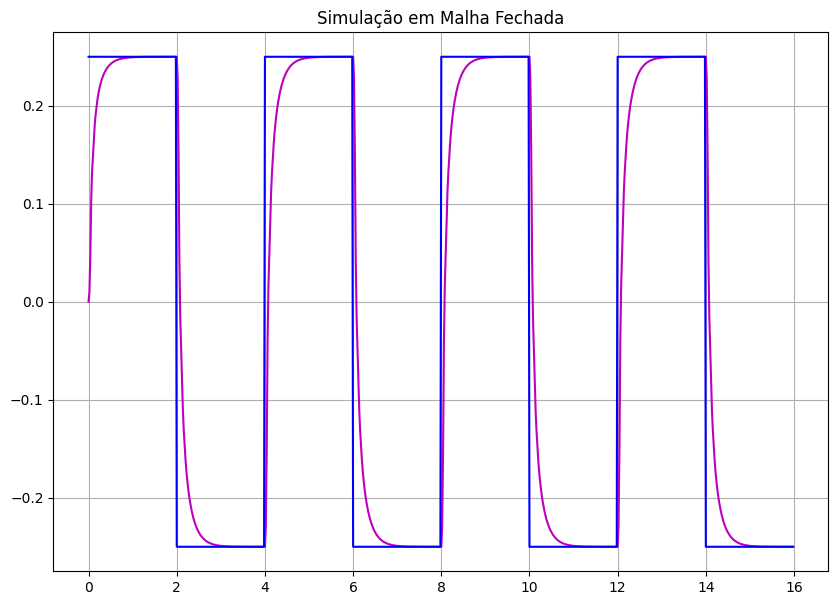

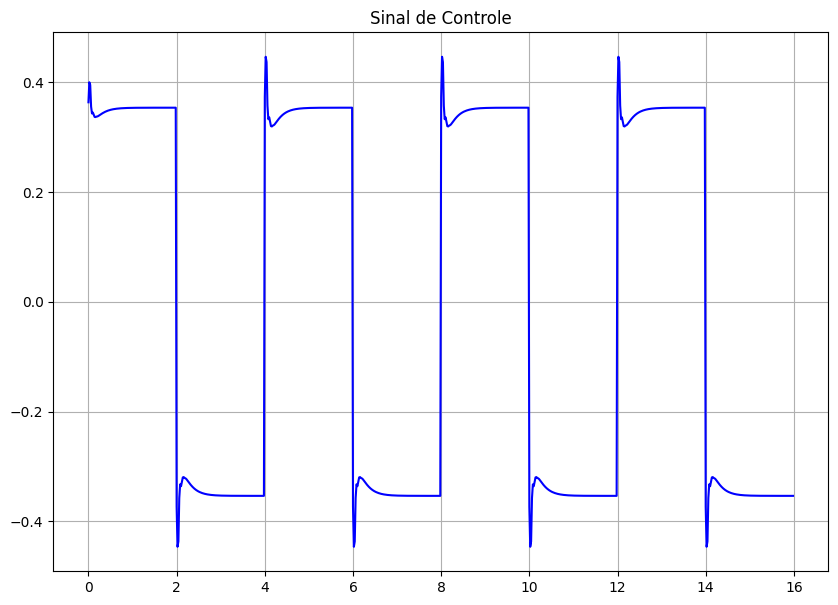

In [71]:

N = 800
Amplutude = 1
freq = 0.25
Fs = 50
Ts =1/Fs

n = np.arange(0,N)
tempo = n*Ts

sinal_de_entrada = Amplutude*square(2*np.pi*freq*n*Ts)

sinal_de_referencia = 0.25*Amplutude*square(2*np.pi*freq*n*Ts)

_,ymf_pi = ct.forced_response(H2, T = tempo, U = sinal_de_referencia)
_,u_pi = ct.forced_response(C,T = tempo, U = sinal_de_referencia)

print(ct.step_info(H2))

plt.figure(figsize=(10,7))
# plt.plot(tempo,ym,'k' ,tempo,y,'r')
plt.plot(tempo,ymf_pi,'m')
plt.plot(tempo,sinal_de_referencia,'b')
plt.title("Simulação em Malha Fechada")
plt.grid()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(tempo,u_pi,'b')
plt.title("Sinal de Controle")
plt.grid()
plt.show()